In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold , cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  
import xgboost as xgb
import joblib


In [2]:
df = pd.read_csv("cardio_train.csv",sep=";")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [4]:
df['age'] = (df['age']/365).round().astype(int)

In [5]:
df = df[(df['height'] >= 120) & (df['height'] <= 220)]
df = df[(df['weight'] >= 30) & (df['weight'] <= 200)]
df = df[(df['ap_hi'] <= 200) & (df['ap_lo'] <= 150)]
df = df[df['ap_hi'] >= df['ap_lo']]
print(f"Data shape after outlier removal: {df.shape}")

Data shape after outlier removal: (68613, 13)


In [6]:
df['bmi'] = df['weight'] / (df['height']/100)**2
print(df['bmi'].describe())

count    68613.000000
mean        27.454384
std          5.254812
min         10.726644
25%         23.875115
50%         26.346494
75%         30.116213
max        108.169847
Name: bmi, dtype: float64


In [ ]:
X = df.drop(['id', 'cardio'], axis=1)
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Train shape after SMOTE: (55500, 12)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
print(f"Train shape after SMOTE: {X_train_scaled.shape}")

In [8]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_xgb = GridSearchCV(xgb_model, params, cv=cv, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_scaled, y_train)

xgb_best = grid_xgb.best_estimator_
y_pred_xgb = xgb_best.predict(X_test_scaled)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, xgb_best.predict_proba(X_test_scaled)[:, 1])
print(f"XGBoost Best Params: {grid_xgb.best_params_}")
print(f"XGBoost Accuracy: {acc_xgb:.4f}, AUC: {auc_xgb:.4f}")

XGBoost Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
XGBoost Accuracy: 0.7318, AUC: 0.8001


In [9]:
rf = RandomForestClassifier(random_state=42)
params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(rf, params_rf, cv=cv, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

rf_best = grid_rf.best_estimator_
y_pred_rf = rf_best.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"RF Best Params: {grid_rf.best_params_}")
print(f"RF Accuracy: {acc_rf:.4f}")

RF Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
RF Accuracy: 0.7343


In [10]:
ensemble = VotingClassifier(estimators=[('xgb', xgb_best), ('rf', rf_best)], voting='soft')
ensemble.fit(X_train_scaled, y_train)
y_pred_ens = ensemble.predict(X_test_scaled)
acc_ens = accuracy_score(y_test, y_pred_ens)
print(f"Ensemble Accuracy: {acc_ens:.4f}")

Ensemble Accuracy: 0.7334


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6938
           1       0.75      0.69      0.72      6785

    accuracy                           0.73     13723
   macro avg       0.73      0.73      0.73     13723
weighted avg       0.73      0.73      0.73     13723

CV Accuracy: 0.7345 (+/- 0.0025)


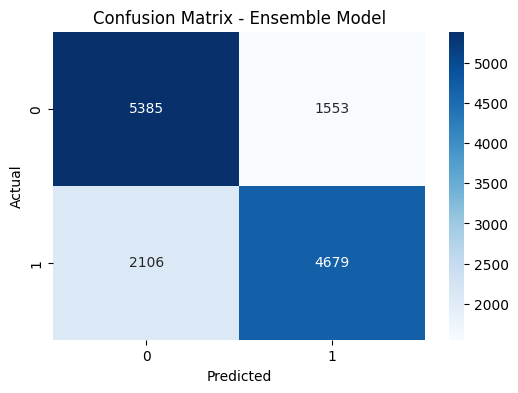

In [11]:
print("Classification Report:")
print(classification_report(y_test, y_pred_ens))

cv_scores = cross_val_score(ensemble, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_ens), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Ensemble Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

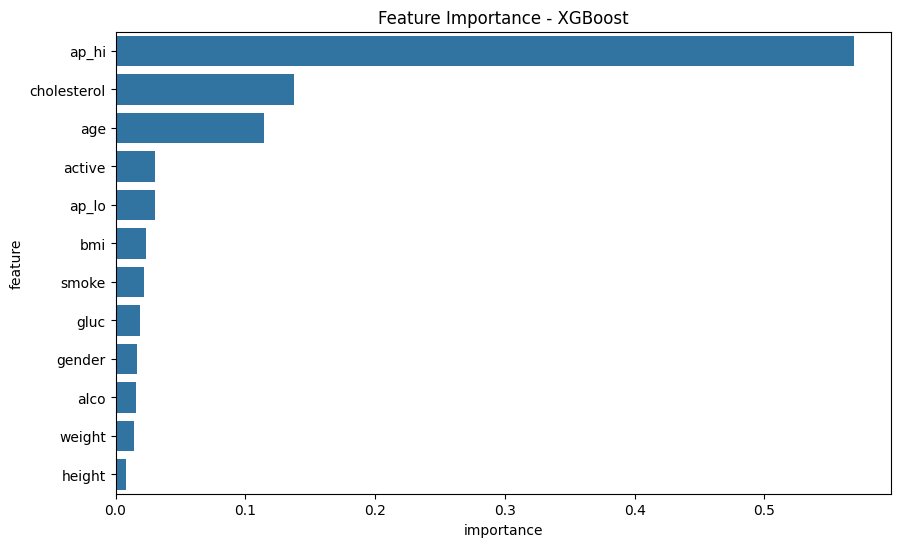

In [12]:
xgb_importance = pd.DataFrame({'feature': X.columns, 'importance': xgb_best.feature_importances_}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance, x='importance', y='feature')
plt.title('Feature Importance - XGBoost')
plt.show()

In [13]:
joblib.dump(ensemble, 'cardio_ensemble_model.joblib', compress=3)
print("Model saved successfully as 'cardio_ensemble_model.joblib'!")

Model saved successfully as 'cardio_ensemble_model.joblib'!
